In [80]:
from tqdm import tqdm
import re
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tensorflow.keras import backend as K 
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,TimeDistributed,Add,Bidirectional,AdditiveAttention
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
import random as rn
np.random.seed(42)
tf.random.set_seed(32)
rn.seed(12)
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [99]:
post_pre=pd.read_csv('/content/gdrive/My Drive/data_with_ent.csv')

In [100]:
max_text_len = 330
max_summary_len = 41

In [101]:
from sklearn.model_selection import train_test_split
x_train,x_validation,y_train,y_validatioin=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary'])
                                                            ,random_state=33,test_size=0.1)

### Considering rare words as unk

In [8]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))


In [9]:
thresh=2
rare_word=[]
for key,value in x_tokenizer.word_counts.items():
    if(value<thresh):
        rare_word.append(key)

In [10]:
print(len(rare_word))
rare_word[:5]

13643


['madiba', 'inferno', 'aback', 'blossomed', 'hodgepodge']

In [11]:
tokenrare=[]
for i in range(len(rare_word)):
    tokenrare.append('ukn')

In [12]:
dictionary_1 = dict(zip(rare_word,tokenrare)) 

In [13]:
x_trunk=[]
for i in x_train:
    for word in i.split():
        if word.lower() in dictionary_1:
            i = i.replace(word, dictionary_1[word.lower()])
    x_trunk.append(i)

In [14]:
x_tokenizer = Tokenizer(oov_token='ukn') 
x_tokenizer.fit_on_texts(list(x_trunk))

### Padding the tokens

In [15]:

# Convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_trunk) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_validation)

# Padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary ( +1 for padding token)
x_voc   =  len(x_tokenizer.word_index) + 1

In [16]:
x_voc

23062

In [17]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_train))

In [18]:
thresh=2
rare_word=[]
for key,value in y_tokenizer.word_counts.items():
    if(value<thresh):
        rare_word.append(key)

In [19]:
print(len(rare_word))
rare_word[3:10]

7814


['lace', 'mazola', 'unleashes', 'stylish', 'conde', 'cheat', 'hack']

In [20]:
tokenrare=[]
for i in range(len(rare_word)):
    tokenrare.append('ukn')

In [21]:
dictionary_1 = dict(zip(rare_word,tokenrare)) 

In [22]:
y_trunk=[]
for i in y_train:
    for word in i.split():
        if word.lower() in dictionary_1:
            i = i.replace(word, dictionary_1[word.lower()])
    y_trunk.append(i)

In [23]:
y_train[3]

'start haiti makeshift camps are starting to function like mini cities citizens are digging out their belongings and what they need out of the rubble everything from turquoise hand crocheted lace to mazola oil seen recently at camp cardinal end'

In [24]:
y_trunk[3]

'start haiti makeshift camps are starting to function like mini cities citizens are digging out their belongings and what they need out of the rubble everything from ukn hand ukn ukn to ukn oil seen recently at camp cardinal end'

In [25]:
y_tokenizer = Tokenizer(oov_token='ukn') 
y_tokenizer.fit_on_texts(list(y_trunk))

# Convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_trunk) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_validatioin) 

# Padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary
y_voc  =   len(y_tokenizer.word_index) +1

In [26]:
y_voc

9480

## Loading pretrained glove vectors

In [27]:
embeddings_dictionary = dict()
glove_file = open("/content/gdrive/My Drive/glove.6B.50d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [28]:
#Updating the dictionary with the pre-trained GloVe embeddings.
embedding_matrix_x = np.zeros((x_voc+1 , 50))
for word, index in x_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_x[index] = embedding_vector
embedding_matrix_x.shape

(23063, 50)

In [29]:
embedding_matrix_y = np.zeros((y_voc+1, 50))

for word, index in y_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_y[index] = embedding_vector
embedding_matrix_y.shape

(9481, 50)

### Attention layer



In [82]:
import tensorflow as tf

K.clear_session()

In [83]:
#Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix_x,enc_units,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,weights=[embedding_matrix_x],
                                   mask_zero=True,name='Encoder_Embedding_layer',trainable=True)
        self.lstm =  Bidirectional(LSTM(self.enc_units,return_sequences=True,return_state=True,name='Encoder_LSTM',dropout=0.2,recurrent_dropout=0.2))

     
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        #state_h = Hidden state output of last time step (Output of last time step)
        #state_c = Cell state output of last time step
        lstm_out, forward_h, forward_c, backward_h, backward_c  = self.lstm(x)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])

        return lstm_out, state_h, state_c

In [84]:

class additiveAttention(tf.keras.layers.AdditiveAttention):
    def __init__(self,units):
        super(additiveAttention,self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1) 

    @tf.function  
    def call(self, keys):
        
        query=keys[0]

        values=keys[1]

        ht_with_time_axis = tf.expand_dims(values, axis=1)

        score = self.V(tf.nn.tanh(self.W1(ht_with_time_axis) + self.W2(query)))

        attention_weights = tf.nn.softmax(score, axis=1)
        
        
        context_vector = attention_weights * query
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [85]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix_y,dec_units,att_units):
        super(OneStepDecoder, self).__init__()
        self.attention = additiveAttention(units=att_units)
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix_y],mask_zero=True,
                                   name='Decoder_Embedding_layer',trainable=True)
        self.lstm = LSTM(dec_units,return_sequences=False,return_state=True,name='Decoder_LSTM')
        self.fc = Dense(vocab_size)

    @tf.function  
    def call(self, x, hidden, cell, enc_output):
        #enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention([enc_output,hidden])

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x,initial_state=[hidden,cell])
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state_h, state_c, attention_weights

In [86]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix_y,dec_units,att_units,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(vocab_size=self.vocab_size,embedding_dim=self.embedding_dim,embedding_matrix_y=embedding_matrix_y,
                                           
                                              dec_units=self.dec_units,
                                              att_units=self.att_units)
        
    @tf.function
    def call(self,decoder_input,decoder_hidden_state,decoder_cell_state,encoder_outputs):

        all_outputs = tf.TensorArray(tf.float32,size=decoder_input.shape[1],name='Output_arrays')
        hidden_output_dec = decoder_hidden_state
        cell_output_dec = decoder_cell_state
        for timestep in range(decoder_input.shape[1]):
            output_dec,hidden_output_dec,cell_output_dec,_ = self.onestep_decoder(decoder_input[:,timestep:timestep+1],
                                                                                  hidden_output_dec,cell_output_dec,
                                                                                  encoder_outputs)
            
            all_outputs = all_outputs.write(timestep,output_dec)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [87]:
class Encoder_Decoder_Attention_Model(tf.keras.models.Model):
    def __init__(self, input_vocab_size,output_vocab_size,embedding_dim,embedding_matrix_x,embedding_matrix_y,units,
                 att_units,**kwargs):
        super(Encoder_Decoder_Attention_Model,self).__init__(**kwargs)
        self.encoder = Encoder(vocab_size=input_vocab_size, embedding_dim=embedding_dim,embedding_matrix_x=embedding_matrix_x,
                               enc_units=units,name='Encoder_layer')
        self.decoder = Decoder(vocab_size=output_vocab_size, embedding_dim=embedding_dim,embedding_matrix_y=embedding_matrix_y,
                               dec_units=units*2,att_units=att_units,name='Decoder_layer')
        
    @tf.function
    def call(self, inputs):
        #Inputs will contain encoder input and decoder input
        #Separate encoder and decoder inputs
        encoder_inputs, decoder_inputs = inputs[0], inputs[1]
        
        #Genearte output and hidden states from encoder object
        encoder_outputs, enc_hidden_output, enc_cell_output = self.encoder(encoder_inputs)

        #Generate output from decoder
        #Initialise hidden states of decoder with hidden states of encoder
        all_outputs = self.decoder(decoder_inputs,enc_hidden_output,enc_cell_output,encoder_outputs)
        
        return all_outputs

In [88]:
#Set Parameters
input_vocab_size = x_voc+1
output_vocab_size = y_voc +1
#Encoding and decoding Embedding layer dimension
embedding_dim = 50

#Encoding and decoding LSTM layer units
units = 64
att_units =128

#Initialise object for Model class
model = Encoder_Decoder_Attention_Model(input_vocab_size,output_vocab_size,embedding_dim,
                                        embedding_matrix_x,embedding_matrix_y,
                                        units,att_units,name='Encoder_Decoder_Attention_Model')

In [89]:
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [90]:
train = data_generator((x_tr,y_tr[:,:-1]), y_tr[:,1:],BATCH_SIZE=64,
                       shuffle=True)
val = data_generator((x_val,y_val[:,:-1]), y_val[:,1:],BATCH_SIZE=16,shuffle=False)


In [91]:
tf.executing_eagerly()

True

In [92]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              ,metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)


history2=model.fit(train ,epochs=5,
                   validation_data=val,
                  workers=-1,callbacks=[es])

Epoch 1/5
111/111 [==============================] - 157s 1s/step - loss: 5.4971 - accuracy: 0.2410 - val_loss: 4.8293 - val_accuracy: 0.3067
Epoch 2/5
111/111 [==============================] - 157s 1s/step - loss: 4.7498 - accuracy: 0.3262 - val_loss: 4.4545 - val_accuracy: 0.3400
Epoch 3/5
111/111 [==============================] - 155s 1s/step - loss: 4.3070 - accuracy: 0.3534 - val_loss: 4.2428 - val_accuracy: 0.3545
Epoch 4/5
111/111 [==============================] - 154s 1s/step - loss: 4.0073 - accuracy: 0.3679 - val_loss: 4.1648 - val_accuracy: 0.3630
Epoch 5/5
111/111 [==============================] - 156s 1s/step - loss: 3.7834 - accuracy: 0.3796 - val_loss: 4.1413 - val_accuracy: 0.3641


In [93]:
model.save_weights('/content/gdrive/My Drive/model_attention_wts.h5')

In [94]:
import joblib
joblib.dump(history2.history,'/content/gdrive/My Drive/model_attention_history2')

['/content/gdrive/My Drive/model_attention_history2']

In [96]:
model.save_weights('/content/gdrive/My Drive/model_attention_wts.h5')
joblib.dump(history2.history,'/content/gdrive/My Drive/model_attention_history3')

['/content/gdrive/My Drive/model_attention_history3']

In [97]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

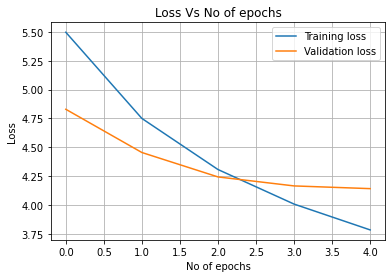

In [98]:
import matplotlib.pyplot as plt
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

### Testing the model

In [102]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [103]:
import spacy
nlp = spacy.load("en_core_web_sm")
token=[]
tag=[]
for i in x_validation1:
    tok=[]
    ta=[]
    doc = nlp(i)
    for ent in doc.ents:
        tok.append(ent.text.lower())
        ta.append(ent.label_.lower())
    token.append(tok)
    tag.append(ta)

In [104]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [105]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

In [106]:
def decode_sequence(model,input_seq,ukn_token,tag,token):
    # Encode the input as state vectors.
    enc_outputs,enc_hidden,enc_cell = model.layers[0](input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    

    target_seq[0, 0] = target_word_index['start']
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    

    

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c,attention_weights = model.layers[1].onestep_decoder(target_seq,dec_hidden,dec_cell,enc_outputs)

        # Sample a token
     
        sampled_token_index = tf.argmax(output_tokens[0]).numpy()
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            if (sampled_token=='ukn'):
            
                decoded_sentence += ' '+ukn_token
            
    
            elif (search(tag,sampled_token)):
                
                idx=tag.index(sampled_token)

                new_token=token[idx]

                decoded_sentence += ' '+new_token

            else:
                decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [109]:
for i in range(1,15):

   
    k= seq2text(x_val[i])
    k=re.sub('[^a-z]+', ' ', k)
    result = text_to_word_sequence(k)
    
    
    if search(result, 'ukn'):
        idx=result.index('ukn')
   
        input_org = re.sub('[^a-z]+',' ', x_validation[i])
        input_org = text_to_word_sequence(input_org)
        ukn_token = input_org[idx]

    else:
        ukn_token='ukn'
    print("Original summary:",seq2summary(y_val[i]))  
    
    print("Predicted summary:",decode_sequence(model,x_val[i].reshape(1,max_text_len),ukn_token,tag[i],token[i]))
    print("\n")

Original summary: person person defends his post match ukn after his side lost to person person was sent to the stands for complaining about red card for norp norp coach says pictures of the incidents back up his claims cardinal 
Predicted summary:  the officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom officialdom


Original summary: deaths of police officers are being investigated isaf public information officer tells the strike occurred amid a joint operation he said dean would not give more details the international security force is a org led mission in gpe cardinal 
Predicted summar